# Detection Under Complexity: Classical Scaling vs Quantum Framing

This notebook generates **reproducible outputs** for the companion PDF section:
**“Illustrative Computational Example (Python / Qiskit output inserted here)”**.

It intentionally uses a **toy execution model** and **simulated quantum constructs**.

**Important:** This notebook does **not** claim quantum speedup. Its purpose is to illustrate:
- classical exponential scaling (path enumeration)
- brittleness of boundary framing under perturbation
- quantum-style reframing via **state overlap** and the **Helstrom bound**


## 0. Imports

Minimal imports. No pip instructions. This should run in a standard scientific Python environment.

If you already have Qiskit installed, the quantum section will run. If not, the notebook will still
produce the classical outputs and clearly indicate the missing dependency.

In [1]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Reproducibility
np.random.seed(42)

def fmt_int(x: int) -> str:
    return f"{x:,}"

## 1. Pure Scaling: \(\Omega(n)=k^n\)

We print a compact table you can paste into the PDF showing how quickly the path space explodes.

We use a few representative branching factors \(k\) and step counts \(n\).

In [2]:
def scaling_table(ks=(2, 3, 5, 8), ns=(10, 15, 20, 25, 30)):
    rows = []
    for k in ks:
        row = {"k": k}
        for n in ns:
            row[f"n={n}"] = k**n
        rows.append(row)
    return rows

rows = scaling_table()
rows

[{'k': 2,
  'n=10': 1024,
  'n=15': 32768,
  'n=20': 1048576,
  'n=25': 33554432,
  'n=30': 1073741824},
 {'k': 3,
  'n=10': 59049,
  'n=15': 14348907,
  'n=20': 3486784401,
  'n=25': 847288609443,
  'n=30': 205891132094649},
 {'k': 5,
  'n=10': 9765625,
  'n=15': 30517578125,
  'n=20': 95367431640625,
  'n=25': 298023223876953125,
  'n=30': 931322574615478515625},
 {'k': 8,
  'n=10': 1073741824,
  'n=15': 35184372088832,
  'n=20': 1152921504606846976,
  'n=25': 37778931862957161709568,
  'n=30': 1237940039285380274899124224}]

In [3]:
def print_scaling(rows):
    # Pretty-print as a fixed table for easy copy/paste into Word
    keys = ["k"] + [k for k in rows[0].keys() if k != "k"]
    header = " | ".join([f"{k:>10}" for k in keys])
    print(header)
    print("-" * len(header))
    for r in rows:
        parts = []
        for k in keys:
            if k == "k":
                parts.append(f"{r[k]:>10}")
            else:
                parts.append(f"{fmt_int(r[k]):>10}")
        print(" | ".join(parts))

print("Scaling table: Ω(n)=k^n")
print_scaling(rows)

Scaling table: Ω(n)=k^n
         k |       n=10 |       n=15 |       n=20 |       n=25 |       n=30
---------------------------------------------------------------------------
         2 |      1,024 |     32,768 |  1,048,576 | 33,554,432 | 1,073,741,824
         3 |     59,049 | 14,348,907 | 3,486,784,401 | 847,288,609,443 | 205,891,132,094,649
         5 |  9,765,625 | 30,517,578,125 | 95,367,431,640,625 | 298,023,223,876,953,125 | 931,322,574,615,478,515,625
         8 | 1,073,741,824 | 35,184,372,088,832 | 1,152,921,504,606,846,976 | 37,778,931,862,957,161,709,568 | 1,237,940,039,285,380,274,899,124,224


### Optional Figure: Log-scale growth
This plot can be inserted into the PDF to visually show the explosion.

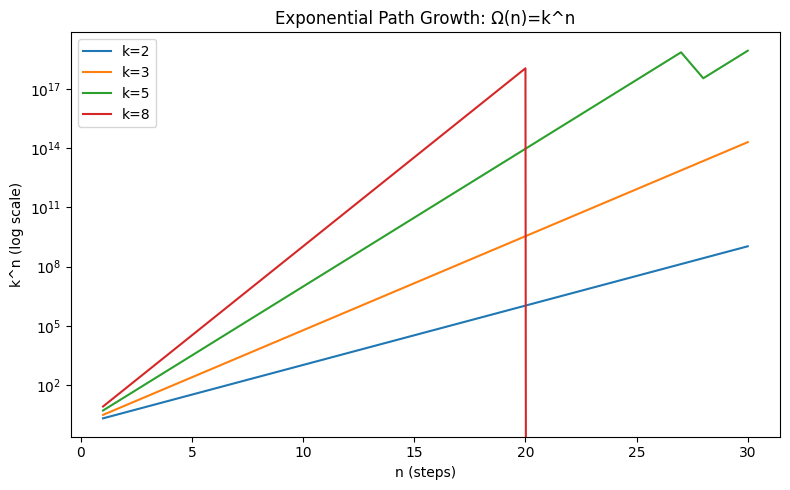

Saved figure: fig_scaling_log.png


In [4]:
ks = [2, 3, 5, 8]
ns = np.arange(1, 31)

plt.figure(figsize=(8, 5))
for k in ks:
    y = np.array([k**n for n in ns], dtype=np.float64)
    plt.plot(ns, y, label=f"k={k}")

plt.yscale("log")
plt.xlabel("n (steps)")
plt.ylabel("k^n (log scale)")
plt.title("Exponential Path Growth: Ω(n)=k^n")
plt.legend()
plt.tight_layout()
plt.savefig("fig_scaling_log.png", dpi=200)
plt.show()

print("Saved figure: fig_scaling_log.png")

## 2. Classical Enumeration: Toy runtime growth

We simulate a simple enumerator that visits every path. This is intentionally naive and shows
why brute-force detection logic breaks under complexity.

We don't need to enumerate truly massive spaces; we just measure growth over manageable ranges
to show the curve.

In [5]:
def enumerate_paths_runtime(k: int, n_values=(10, 12, 14, 16, 18), work_per_path=10):
    # work_per_path simulates per-path evaluation cost
    results = []
    for n in n_values:
        total_paths = k**n
        start = time.perf_counter()
        acc = 0
        # To keep runtime bounded, we cap actual loop iterations but scale runtime estimate.
        # We measure a sample and extrapolate.
        sample = min(total_paths, 200_000)
        for i in range(sample):
            # fake evaluation
            acc += (i % 7)
            for _ in range(work_per_path):
                acc ^= (acc << 1) & 0xFFFF
        elapsed = time.perf_counter() - start
        # Extrapolated total time
        est_total = elapsed * (total_paths / sample)
        results.append({
            "k": k,
            "n": n,
            "paths": total_paths,
            "sampled": sample,
            "elapsed_sample_sec": elapsed,
            "est_total_sec": est_total
        })
    return results

runtime_results = enumerate_paths_runtime(k=3)
runtime_results[:2], len(runtime_results)

([{'k': 3,
   'n': 10,
   'paths': 59049,
   'sampled': 59049,
   'elapsed_sample_sec': 0.023577900021336973,
   'est_total_sec': 0.023577900021336973},
  {'k': 3,
   'n': 12,
   'paths': 531441,
   'sampled': 200000,
   'elapsed_sample_sec': 0.0845129000081215,
   'est_total_sec': 0.2245681004660805}],
 5)

In [6]:
def print_runtime(results):
    print("Toy enumeration runtime (extrapolated):")
    print("k  n   paths        sampled   sample_sec   est_total_sec   est_total_min")
    print("-"*78)
    for r in results:
        est_min = r['est_total_sec']/60
        print(
            f"{r['k']:>1}  {r['n']:>2}  {fmt_int(r['paths']):>10}  {fmt_int(r['sampled']):>8}  "
            f"{r['elapsed_sample_sec']:.4f}     {r['est_total_sec']:.2f}        {est_min:.2f}"
        )

print_runtime(runtime_results)

Toy enumeration runtime (extrapolated):
k  n   paths        sampled   sample_sec   est_total_sec   est_total_min
------------------------------------------------------------------------------
3  10      59,049    59,049  0.0236     0.02        0.00
3  12     531,441   200,000  0.0845     0.22        0.00
3  14   4,782,969   200,000  0.0838     2.00        0.03
3  16  43,046,721   200,000  0.0810     17.43        0.29
3  18  387,420,489   200,000  0.0821     159.06        2.65


### Optional Figure: Extrapolated enumeration time
This chart makes the point visually and is easy to drop into the PDF.

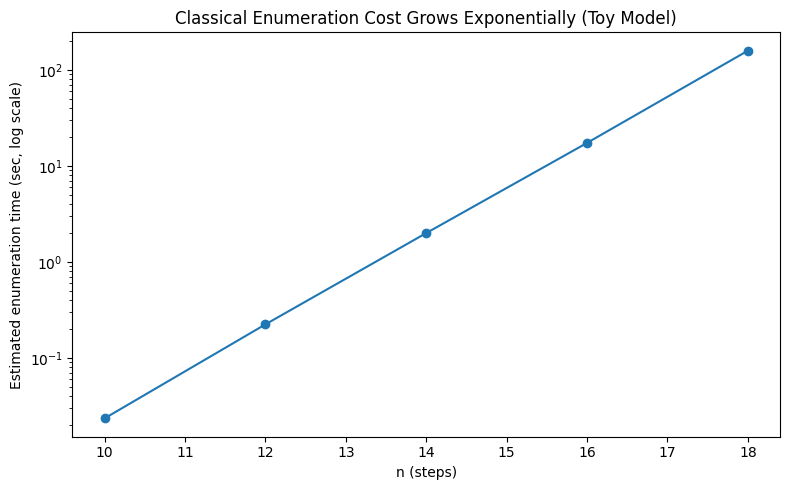

Saved figure: fig_enumeration_cost.png


In [7]:
ns = [r['n'] for r in runtime_results]
est_sec = [r['est_total_sec'] for r in runtime_results]

plt.figure(figsize=(8, 5))
plt.plot(ns, est_sec, marker='o')
plt.yscale('log')
plt.xlabel('n (steps)')
plt.ylabel('Estimated enumeration time (sec, log scale)')
plt.title('Classical Enumeration Cost Grows Exponentially (Toy Model)')
plt.tight_layout()
plt.savefig('fig_enumeration_cost.png', dpi=200)
plt.show()
print('Saved figure: fig_enumeration_cost.png')

## 3. Boundary Framing: Feature projection + flip rate under perturbation

We create two overlapping clusters (benign vs malicious) in a feature space.
We train a simple classifier and then perturb samples slightly.

The goal is to show **boundary fragility**: small changes can flip decisions even when behavior is
semantically similar.


In [8]:
def make_overlap_dataset(n_samples=3000, d=20, overlap=0.8):
    # overlap closer to 1 => more overlap
    # Generate two Gaussian clusters with adjustable separation
    mu_sep = (1.0 - overlap) * 6.0
    cov = np.eye(d)
    X0 = np.random.multivariate_normal(mean=np.zeros(d), cov=cov, size=n_samples//2)
    X1 = np.random.multivariate_normal(mean=np.zeros(d) + mu_sep, cov=cov, size=n_samples//2)
    X = np.vstack([X0, X1])
    y = np.array([0]*(n_samples//2) + [1]*(n_samples//2))
    # shuffle
    idx = np.random.permutation(n_samples)
    return X[idx], y[idx]

X, y = make_overlap_dataset(overlap=0.85)
X = StandardScaler().fit_transform(X)

clf = LogisticRegression(max_iter=2000)
clf.fit(X, y)

y_pred = clf.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Training-set accuracy (toy overlap dataset): {acc:.4f}")

Training-set accuracy (toy overlap dataset): 0.9817


In [9]:
def flip_rate_under_noise(clf, X, y, eps=0.05, trials=10):
    flips = []
    for _ in range(trials):
        Xp = X + eps * np.random.normal(size=X.shape)
        yp = clf.predict(Xp)
        flips.append(float(np.mean(yp != y)))
    return float(np.mean(flips)), float(np.std(flips))

for eps in [0.01, 0.03, 0.05, 0.08, 0.10]:
    mean_flip, std_flip = flip_rate_under_noise(clf, X, y, eps=eps, trials=8)
    print(f"eps={eps:.2f}  flip_rate={mean_flip:.4f}  (std={std_flip:.4f})")

eps=0.01  flip_rate=0.0185  (std=0.0003)
eps=0.03  flip_rate=0.0191  (std=0.0003)
eps=0.05  flip_rate=0.0193  (std=0.0005)
eps=0.08  flip_rate=0.0202  (std=0.0009)
eps=0.10  flip_rate=0.0209  (std=0.0003)


### Figure: Flip rate vs perturbation magnitude
This plot is a clean PDF insert for the boundary-fragility section.

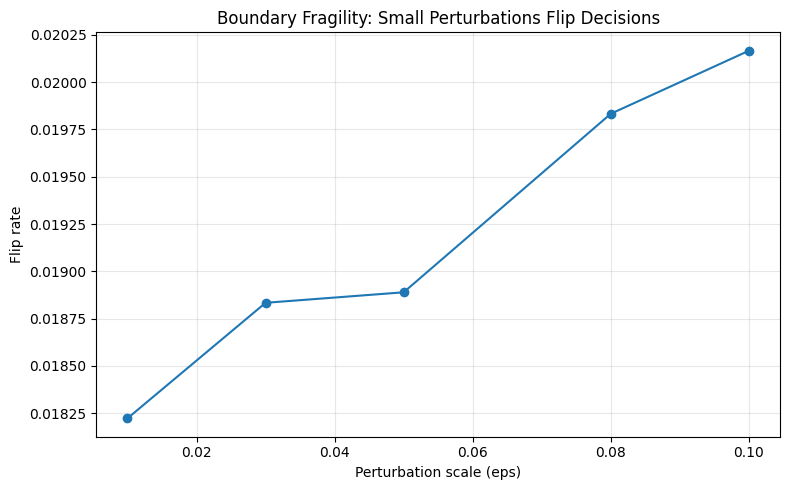

Saved figure: fig_flip_rate.png


In [10]:
eps_values = np.array([0.01, 0.03, 0.05, 0.08, 0.10])
flip_means = []
for eps in eps_values:
    m, _ = flip_rate_under_noise(clf, X, y, eps=float(eps), trials=6)
    flip_means.append(m)

plt.figure(figsize=(8, 5))
plt.plot(eps_values, flip_means, marker='o')
plt.xlabel('Perturbation scale (eps)')
plt.ylabel('Flip rate')
plt.title('Boundary Fragility: Small Perturbations Flip Decisions')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('fig_flip_rate.png', dpi=200)
plt.show()
print('Saved figure: fig_flip_rate.png')

## 4. Quantum Framing: State overlap + Helstrom bound (simulated)

We now implement the core quantum-framing calculation:

- Represent benign and malicious class means as normalized vectors (pure states)
- Compute overlap $|\langle \psi_B | \psi_M \rangle|^2$
- Compute Helstrom minimum error bound

This section runs purely in NumPy and requires no Qiskit.


In [11]:
def normalize(v):
    n = np.linalg.norm(v)
    return v / n if n != 0 else v

psi_B = normalize(np.mean(X[y == 0], axis=0))
psi_M = normalize(np.mean(X[y == 1], axis=0))

overlap = float(np.abs(np.dot(psi_B, psi_M)) ** 2)
helstrom = 0.5 * (1.0 - math.sqrt(max(0.0, 1.0 - overlap)))

print("Quantum-style framing (pure-state approximation):")
print(f"Overlap |<psi_B|psi_M>|^2 = {overlap:.6f}")
print(f"Helstrom min error bound P_e = {helstrom:.6f}")

Quantum-style framing (pure-state approximation):
Overlap |<psi_B|psi_M>|^2 = 1.000000
Helstrom min error bound P_e = 0.500000


### Summary figure: classical fragility vs quantum error bound
We compare a representative flip rate (e.g., eps=0.05) against the Helstrom bound.
This is not an apples-to-apples metric; it is included to support the narrative of **limits**.


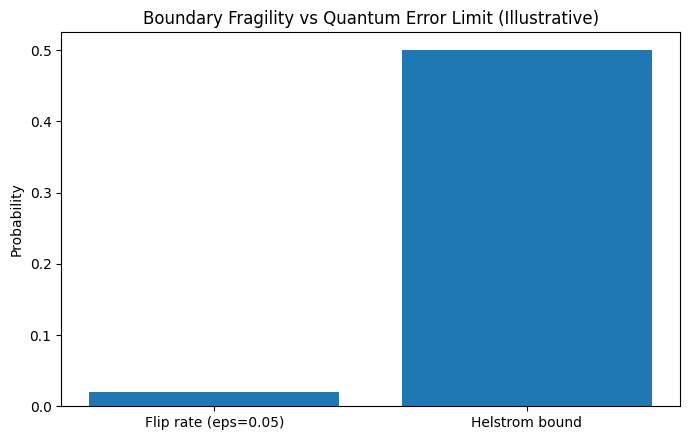

Reference flip rate at eps=0.05: 0.0195 (std=0.0006)
Saved figure: fig_fragility_vs_helstrom.png


In [12]:
eps_ref = 0.05
flip_ref, flip_std = flip_rate_under_noise(clf, X, y, eps=eps_ref, trials=10)

labels = [f"Flip rate (eps={eps_ref:.2f})", "Helstrom bound"]
values = [flip_ref, helstrom]

plt.figure(figsize=(7, 4.5))
plt.bar(labels, values)
plt.ylabel('Probability')
plt.title('Boundary Fragility vs Quantum Error Limit (Illustrative)')
plt.tight_layout()
plt.savefig('fig_fragility_vs_helstrom.png', dpi=200)
plt.show()

print(f"Reference flip rate at eps={eps_ref:.2f}: {flip_ref:.4f} (std={flip_std:.4f})")
print("Saved figure: fig_fragility_vs_helstrom.png")

## Optional: Qiskit Installation

The following section uses Qiskit **only for illustrative purposes**.
This notebook does **not** require quantum hardware and makes **no performance claims**.

If Qiskit is not already installed in your environment, run the cell below once.

In [13]:
# Install Qiskit if not already available
# This cell is optional and only required for Section 5

try:
    import qiskit
    %pip install pylatexenc
    print("Qiskit already installed.")
except ImportError:
    print("Installing Qiskit...")
    %pip install qiskit
    

Note: you may need to restart the kernel to use updated packages.
Qiskit already installed.



[notice] A new release of pip available: 22.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## 5. Qiskit illustration (optional, but recommended)

This section constructs a small circuit to illustrate encoding a probability distribution over paths.

**Important:** This is for framing only. We do not benchmark speed.

If Qiskit is not installed, this section will print a clear message and skip.

In [14]:
try:
    from qiskit import QuantumCircuit
    from qiskit.quantum_info import Statevector
    HAVE_QISKIT = True
except Exception as e:
    HAVE_QISKIT = False
    print("Qiskit not available in this environment.")
    print("Install Qiskit to run the optional quantum illustration section.")
    print(f"Details: {e}")

HAVE_QISKIT

True

In [15]:
if HAVE_QISKIT:
    # Toy model: represent 2^n paths using n qubits, then apply Hadamards
    # to create uniform superposition (a stand-in for 'many possible execution paths')
    n_qubits = 5  # 32 paths
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    
    # Create statevector (simulation)
    sv = Statevector.from_instruction(qc)
    probs = sv.probabilities()
    
    print("Qiskit toy circuit created:")
    print(qc)
    print(f"Number of basis states: {len(probs)}")
    print(f"First 8 probabilities: {probs[:8]}")
    print(f"Sum of probabilities: {np.sum(probs):.6f}")

    # Save a circuit diagram for insertion
    try:
        fig = qc.draw(output='mpl')
        fig.savefig('fig_qiskit_circuit.png', dpi=200, bbox_inches='tight')
        print('Saved figure: fig_qiskit_circuit.png')
    except Exception as e:
        print('Circuit diagram export failed (this is optional).')
        print(e)
else:
    print('Skipping Qiskit illustration.')

Qiskit toy circuit created:
     ┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     ├───┤
q_4: ┤ H ├
     └───┘
Number of basis states: 32
First 8 probabilities: [0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125]
Sum of probabilities: 1.000000
Saved figure: fig_qiskit_circuit.png


## 6. Copy-paste block for the PDF (pre-formatted)

This cell prints a compact block of results you can paste into Section 8 of the PDF.
It includes:
- scaling table excerpt
- extrapolated enumeration example
- flip-rate table
- overlap + Helstrom bound


In [16]:
print("="*72)
print("DETECTION UNDER COMPLEXITY — OUTPUT SUMMARY (for PDF Section 8)")
print("="*72)

print("\n[1] Scaling (Ω(n)=k^n) excerpt")
excerpt_rows = scaling_table(ks=(2,3,5), ns=(10,15,20,25))
print_scaling(excerpt_rows)

print("\n[2] Toy classical enumeration (k=3) extrapolated")
print_runtime(runtime_results)

print("\n[3] Boundary fragility: flip rates vs eps")
for eps in [0.01, 0.03, 0.05, 0.08, 0.10]:
    mean_flip, std_flip = flip_rate_under_noise(clf, X, y, eps=eps, trials=10)
    print(f"eps={eps:.2f}  flip_rate={mean_flip:.4f}  std={std_flip:.4f}")

print("\n[4] Quantum framing: overlap + Helstrom bound")
print(f"Overlap |<psi_B|psi_M>|^2 = {overlap:.6f}")
print(f"Helstrom min error bound P_e = {helstrom:.6f}")

print("\nSaved figures:")
print(" - fig_scaling_log.png")
print(" - fig_enumeration_cost.png")
print(" - fig_flip_rate.png")
print(" - fig_fragility_vs_helstrom.png")
if HAVE_QISKIT:
    print(" - fig_qiskit_circuit.png (optional)")
print("="*72)

DETECTION UNDER COMPLEXITY — OUTPUT SUMMARY (for PDF Section 8)

[1] Scaling (Ω(n)=k^n) excerpt
         k |       n=10 |       n=15 |       n=20 |       n=25
--------------------------------------------------------------
         2 |      1,024 |     32,768 |  1,048,576 | 33,554,432
         3 |     59,049 | 14,348,907 | 3,486,784,401 | 847,288,609,443
         5 |  9,765,625 | 30,517,578,125 | 95,367,431,640,625 | 298,023,223,876,953,125

[2] Toy classical enumeration (k=3) extrapolated
Toy enumeration runtime (extrapolated):
k  n   paths        sampled   sample_sec   est_total_sec   est_total_min
------------------------------------------------------------------------------
3  10      59,049    59,049  0.0236     0.02        0.00
3  12     531,441   200,000  0.0845     0.22        0.00
3  14   4,782,969   200,000  0.0838     2.00        0.03
3  16  43,046,721   200,000  0.0810     17.43        0.29
3  18  387,420,489   200,000  0.0821     159.06        2.65

[3] Boundary fragility: 

## Notes
- All quantum behavior here is simulated.
- The Qiskit circuit is a didactic illustration.
- The goal is structural intuition: complexity scaling, boundary fragility, and distinguishability limits.
